In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 769.5629, train_label_loss: 2.7829, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 12435.2898, train_label_loss: 2.7131, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 12649.9071, train_label_loss: 2.6182, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 12608.1572, train_label_loss: 2.5195, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 12559.2254, train_label_loss: 2.2637, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 12640.3274, train_label_loss: 2.1372, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 12556.3740, train_label_loss: 2.0611, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 12539.4417, train_label_loss: 1.8107, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 12475.9012, train_label_loss: 1.8371, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 12479.4724, train_label_loss: 1.4625, 


epoch: 1, source_val_acc_label: 0.5827, source_val_label_loss: 1.3978, target_val_acc_label: 0.5827, target_val_label_loss: 1.3978, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 60.4444, train_label_loss: 1.4487, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 12281.5340, train_label_loss: 1.3572, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 12345.0345, train_label_loss: 1.2037, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 13077.0728, train_label_loss: 1.1758, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 12540.6091, train_label_loss: 1.1715, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 12390.7659, train_label_loss: 0.8529, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11543.5133, train_label_loss: 0.9132, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 12379.7943, train_label_loss: 0.8490, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 12327.5892, train_label_loss: 0.7408, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 12309.5500, train_label_loss: 0.6670, 


epoch: 2, source_val_acc_label: 0.8384, source_val_label_loss: 0.6727, target_val_acc_label: 0.8384, target_val_label_loss: 0.6727, 


New best


epoch: 3, [batch: 1 / 1400], examples_per_second: 64.3148, train_label_loss: 0.6611, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 12207.5098, train_label_loss: 0.5853, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 12283.6870, train_label_loss: 0.5616, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 12072.9718, train_label_loss: 0.6227, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 12480.3572, train_label_loss: 0.5673, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 12435.2675, train_label_loss: 0.3979, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 12544.5817, train_label_loss: 0.5385, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 12238.5857, train_label_loss: 0.4154, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 12461.0524, train_label_loss: 0.4333, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 12243.8469, train_label_loss: 0.3513, 


epoch: 3, source_val_acc_label: 0.9102, source_val_label_loss: 0.3759, target_val_acc_label: 0.9102, target_val_label_loss: 0.3759, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 68.6008, train_label_loss: 0.2883, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11500.1602, train_label_loss: 0.3139, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 12280.0665, train_label_loss: 0.3541, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12186.9675, train_label_loss: 0.3136, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12221.1059, train_label_loss: 0.6450, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11147.9577, train_label_loss: 0.2742, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11302.0696, train_label_loss: 0.4244, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 12328.2625, train_label_loss: 0.3257, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 12390.2573, train_label_loss: 0.2601, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 12540.1174, train_label_loss: 0.2777, 


epoch: 4, source_val_acc_label: 0.9220, source_val_label_loss: 0.3068, target_val_acc_label: 0.9220, target_val_label_loss: 0.3068, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 69.4845, train_label_loss: 0.3510, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 12453.9424, train_label_loss: 0.2838, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 12451.0366, train_label_loss: 0.3322, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 12399.3327, train_label_loss: 0.3184, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 12493.0153, train_label_loss: 0.3001, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 12359.9027, train_label_loss: 0.2526, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 12448.9311, train_label_loss: 0.2168, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 12427.6434, train_label_loss: 0.2469, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 12488.6042, train_label_loss: 0.2316, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 12485.5588, train_label_loss: 0.2608, 


epoch: 5, source_val_acc_label: 0.9406, source_val_label_loss: 0.2344, target_val_acc_label: 0.9406, target_val_label_loss: 0.2344, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 69.0535, train_label_loss: 0.1880, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 12378.8399, train_label_loss: 0.2507, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 12473.3194, train_label_loss: 0.2138, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 12441.4385, train_label_loss: 0.2210, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 12380.9383, train_label_loss: 0.1484, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 12434.2348, train_label_loss: 0.1603, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 12490.3890, train_label_loss: 0.1888, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 12556.7978, train_label_loss: 0.2770, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 12361.0613, train_label_loss: 0.1621, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 12461.3932, train_label_loss: 0.1885, 


epoch: 6, source_val_acc_label: 0.9322, source_val_label_loss: 0.2329, target_val_acc_label: 0.9322, target_val_label_loss: 0.2329, 


epoch: 7, [batch: 1 / 1400], examples_per_second: 69.9432, train_label_loss: 0.1992, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 12233.5978, train_label_loss: 0.1387, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 12236.8183, train_label_loss: 0.1677, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 12204.8471, train_label_loss: 0.1137, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 12467.0402, train_label_loss: 0.1889, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 12393.9819, train_label_loss: 0.1203, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 12435.7201, train_label_loss: 0.1677, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 12563.8167, train_label_loss: 0.1460, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 12548.8501, train_label_loss: 0.1571, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 12407.5283, train_label_loss: 0.3468, 


epoch: 7, source_val_acc_label: 0.9506, source_val_label_loss: 0.2077, target_val_acc_label: 0.9506, target_val_label_loss: 0.2077, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 70.2287, train_label_loss: 0.1781, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 12110.8201, train_label_loss: 0.1826, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 12345.3488, train_label_loss: 0.1748, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 12339.6738, train_label_loss: 0.1246, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 12442.9627, train_label_loss: 0.1629, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 12437.9262, train_label_loss: 0.1979, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 12447.7889, train_label_loss: 0.1330, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 12550.1220, train_label_loss: 0.1116, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 12536.3756, train_label_loss: 0.1616, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 12492.2408, train_label_loss: 0.2280, 


epoch: 8, source_val_acc_label: 0.9510, source_val_label_loss: 0.2586, target_val_acc_label: 0.9510, target_val_label_loss: 0.2586, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 70.0637, train_label_loss: 0.2440, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 12373.4090, train_label_loss: 0.1732, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 12431.1048, train_label_loss: 0.2181, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 12377.6618, train_label_loss: 0.1186, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 12418.3871, train_label_loss: 0.2427, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 12487.7992, train_label_loss: 0.1359, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 12458.2888, train_label_loss: 0.2904, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 12251.4787, train_label_loss: 0.0995, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 12406.1746, train_label_loss: 0.1607, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 12467.9336, train_label_loss: 0.1480, 


epoch: 9, source_val_acc_label: 0.9571, source_val_label_loss: 0.1641, target_val_acc_label: 0.9571, target_val_label_loss: 0.1641, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 69.3590, train_label_loss: 0.1528, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 12587.0032, train_label_loss: 0.1771, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 12410.9436, train_label_loss: 0.1178, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 12432.6634, train_label_loss: 0.0681, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 12442.7464, train_label_loss: 0.0822, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 12404.0002, train_label_loss: 0.0682, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 12349.1073, train_label_loss: 0.1687, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 12384.8858, train_label_loss: 0.0711, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 12401.8901, train_label_loss: 0.1796, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 12443.2325, train_label_loss: 0.1290, 


epoch: 10, source_val_acc_label: 0.9583, source_val_label_loss: 0.1625, target_val_acc_label: 0.9583, target_val_label_loss: 0.1625, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 80.7280, train_label_loss: 0.1691, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 13734.8660, train_label_loss: 0.0984, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 13904.5975, train_label_loss: 0.0880, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 13836.0361, train_label_loss: 0.1155, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 12397.4266, train_label_loss: 0.3931, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 13745.6246, train_label_loss: 0.1395, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 13626.4271, train_label_loss: 0.0926, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 13561.1866, train_label_loss: 0.1003, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 13687.8923, train_label_loss: 0.1608, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 13699.3385, train_label_loss: 0.0917, 


epoch: 11, source_val_acc_label: 0.9538, source_val_label_loss: 0.2148, target_val_acc_label: 0.9538, target_val_label_loss: 0.2148, 


epoch: 12, [batch: 1 / 1400], examples_per_second: 77.9835, train_label_loss: 0.1099, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 13946.8152, train_label_loss: 0.0732, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 13830.8320, train_label_loss: 0.1297, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 13785.1746, train_label_loss: 0.0706, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 13883.3931, train_label_loss: 0.1102, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 13905.9867, train_label_loss: 0.1060, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 12015.9189, train_label_loss: 0.2394, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 11625.9353, train_label_loss: 0.0762, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 11670.2931, train_label_loss: 0.0786, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 11675.4289, train_label_loss: 0.0906, 


epoch: 12, source_val_acc_label: 0.9601, source_val_label_loss: 0.4807, target_val_acc_label: 0.9601, target_val_label_loss: 0.4807, 


New best
epoch: 13, [batch: 1 / 1400], examples_per_second: 63.6561, train_label_loss: 0.1451, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 11539.8531, train_label_loss: 0.1840, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 11672.6565, train_label_loss: 0.7459, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 11704.8600, train_label_loss: 0.1547, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 11695.5221, train_label_loss: 0.0904, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 11662.3546, train_label_loss: 0.1054, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 11670.9745, train_label_loss: 0.1239, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 11687.5165, train_label_loss: 0.1158, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 11605.0696, train_label_loss: 0.1526, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 11606.1735, train_label_loss: 0.0732, 


epoch: 13, source_val_acc_label: 0.9567, source_val_label_loss: 0.2351, target_val_acc_label: 0.9567, target_val_label_loss: 0.2351, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 65.3268, train_label_loss: 0.0767, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 11632.7119, train_label_loss: 0.0765, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 11581.7992, train_label_loss: 0.1362, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 11562.2937, train_label_loss: 0.0699, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 12319.1011, train_label_loss: 0.0657, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 11696.6887, train_label_loss: 0.1365, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 11586.1679, train_label_loss: 0.0705, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 11581.1497, train_label_loss: 0.1198, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 11598.1716, train_label_loss: 0.1291, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 11613.7432, train_label_loss: 0.0657, 


epoch: 14, source_val_acc_label: 0.9632, source_val_label_loss: 0.3336, target_val_acc_label: 0.9632, target_val_label_loss: 0.3336, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 64.3263, train_label_loss: 0.0607, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 11447.1937, train_label_loss: 0.0508, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 11538.0430, train_label_loss: 0.1494, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 11602.2894, train_label_loss: 0.0662, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 11600.6473, train_label_loss: 0.1310, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 11709.8548, train_label_loss: 0.0675, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 11565.7952, train_label_loss: 0.0878, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 11527.5300, train_label_loss: 0.1248, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 11632.7674, train_label_loss: 0.1310, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 11629.9433, train_label_loss: 0.1514, 


epoch: 15, source_val_acc_label: 0.9638, source_val_label_loss: 0.2691, target_val_acc_label: 0.9638, target_val_label_loss: 0.2691, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 64.0996, train_label_loss: 0.1125, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 11606.4580, train_label_loss: 0.0926, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 11564.9267, train_label_loss: 0.0757, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 11575.6258, train_label_loss: 0.0940, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 11634.6437, train_label_loss: 0.1126, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 11538.5479, train_label_loss: 0.0995, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 11649.8025, train_label_loss: 0.1339, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 11569.8473, train_label_loss: 0.0705, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 11585.1429, train_label_loss: 0.1353, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 11562.2262, train_label_loss: 0.1119, 


epoch: 16, source_val_acc_label: 0.9704, source_val_label_loss: 0.2006, target_val_acc_label: 0.9704, target_val_label_loss: 0.2006, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 63.9296, train_label_loss: 0.0713, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 11485.4658, train_label_loss: 0.2547, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 11660.2396, train_label_loss: 0.0828, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 11554.9526, train_label_loss: 0.0684, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 11539.2387, train_label_loss: 0.0853, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 11574.1660, train_label_loss: 0.0938, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 11568.6630, train_label_loss: 0.1159, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 11607.9444, train_label_loss: 0.1085, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 11689.2196, train_label_loss: 0.0639, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 11656.9085, train_label_loss: 0.0483, 


epoch: 17, source_val_acc_label: 0.9539, source_val_label_loss: 0.3381, target_val_acc_label: 0.9539, target_val_label_loss: 0.3381, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 64.4633, train_label_loss: 0.0797, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 11565.6503, train_label_loss: 0.0494, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 11634.2962, train_label_loss: 0.0328, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 11601.7718, train_label_loss: 0.0435, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 11584.3483, train_label_loss: 0.0709, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 11548.8131, train_label_loss: 0.1462, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 11600.7708, train_label_loss: 0.0787, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 11494.3561, train_label_loss: 0.0678, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 11523.8750, train_label_loss: 0.1093, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 11588.4152, train_label_loss: 0.0559, 


epoch: 18, source_val_acc_label: 0.9661, source_val_label_loss: 0.3158, target_val_acc_label: 0.9661, target_val_label_loss: 0.3158, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 64.7254, train_label_loss: 0.0693, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 11498.7514, train_label_loss: 0.0399, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 11596.4555, train_label_loss: 0.1403, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 11588.1936, train_label_loss: 0.0757, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 11610.3633, train_label_loss: 0.0702, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 11620.4693, train_label_loss: 0.0440, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 11555.4447, train_label_loss: 0.0640, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 11625.8904, train_label_loss: 0.0530, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 11653.1313, train_label_loss: 0.0561, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 11630.5570, train_label_loss: 0.0292, 


epoch: 19, source_val_acc_label: 0.9618, source_val_label_loss: 0.3635, target_val_acc_label: 0.9618, target_val_label_loss: 0.3635, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 64.3814, train_label_loss: 0.0711, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11564.0301, train_label_loss: 0.1927, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 11618.0157, train_label_loss: 0.1179, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 11571.4325, train_label_loss: 0.0351, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 11633.0447, train_label_loss: 0.0848, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 11611.5094, train_label_loss: 0.0694, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 11643.1037, train_label_loss: 0.0836, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 11621.2814, train_label_loss: 0.0778, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 11602.9485, train_label_loss: 0.0916, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 12158.4904, train_label_loss: 0.0482, 


epoch: 20, source_val_acc_label: 0.9670, source_val_label_loss: 0.4080, target_val_acc_label: 0.9670, target_val_label_loss: 0.4080, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

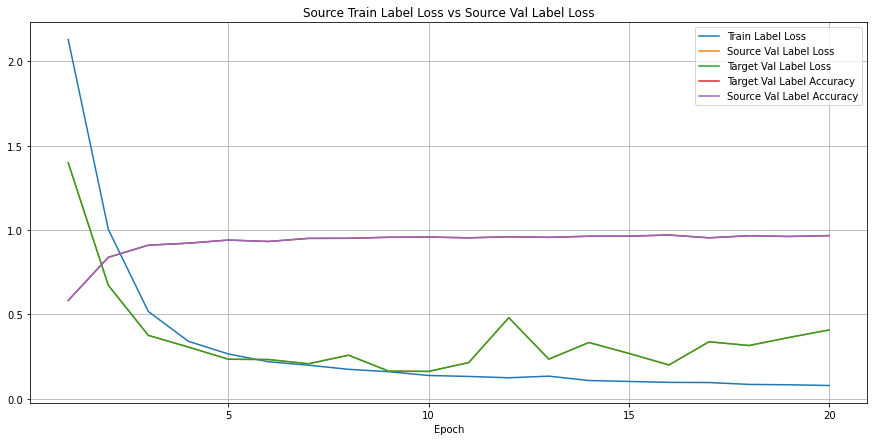

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

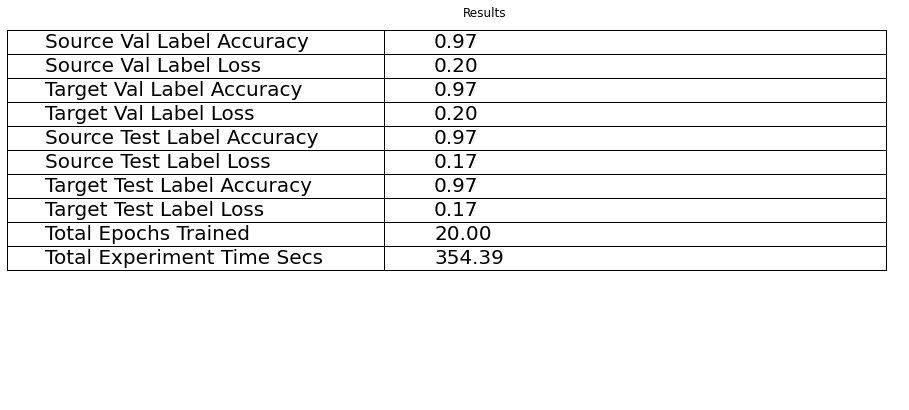

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

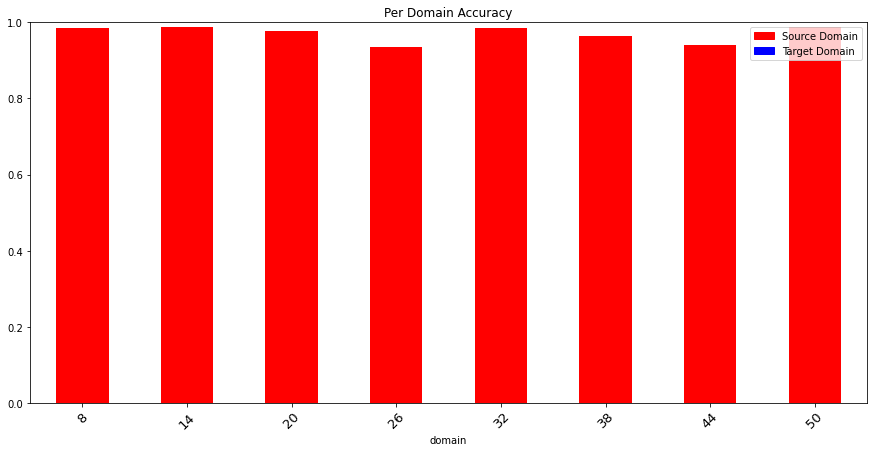

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9694010416666666 Target Test Label Accuracy: 0.9694010416666666
Source Val Label Accuracy: 0.9704427083333333 Target Val Label Accuracy: 0.9704427083333333


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2.framed", "parameters": {"experiment_name": "cnn_2:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch